In [1]:
import math
import networkx as nx
import pickle
import matplotlib.pyplot as plt
import json
import gcol
import random
import os

In [2]:
with open("LACountyFireHazardLevel.json") as file:
    full_data = json.load(file)

centroids = {}

for idx, feature in enumerate(full_data['features']):
    attributes = feature.get('attributes', {})
    geometry = feature.get('geometry', {})

    if 'rings' in geometry and geometry['rings']:
        points = geometry['rings'][0]
        num_points = len(points)

        avg_lon = sum(p[0] for p in points) / num_points
        avg_lat = sum(p[1] for p in points) / num_points
        hazard_level = attributes.get('HAZ_CLASS', 'Unknown')

        centroids[idx] = (hazard_level, avg_lat, avg_lon)

random.seed(3)
indices = random.sample(sorted(centroids.keys()), 50)
sample = {}
for idx in indices:
    sample[len(sample)+1] = centroids[idx]

In [3]:
def euclidean(p1, p2):
    return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)
epsilon = 0.2

In [4]:
distance_matrix = {}
for id1, attributes1 in sample.items():
    hazard_level1 = attributes1[0]
    coord1 = (attributes1[1], attributes1[2])
    if hazard_level1 not in distance_matrix.keys():
        distance_matrix[hazard_level1] = {}
    distance_matrix[hazard_level1][id1] = {}
    for id2, attributes2 in sample.items():
        hazard_level2 = attributes2[0]
        coord2 = (attributes2[1], attributes2[2])
        if id1 != id2 and hazard_level1 == hazard_level2:
            distance_matrix[hazard_level1][id1][id2] = euclidean(coord1, coord2)

In [5]:
moderateGraph = {}
for id1 in distance_matrix["Moderate"].keys():
    for id2 in distance_matrix["Moderate"][id1].keys():
        dist = distance_matrix["Moderate"][id1][id2]
        if id1 not in moderateGraph.keys():
                moderateGraph[id1] = {}
        if dist < epsilon:
            if id2 not in moderateGraph[id1].keys():
                moderateGraph[id1][id2] = 1
        
highGraph = {}
for id1 in distance_matrix["High"].keys():
    for id2 in distance_matrix["High"][id1].keys():
        dist = distance_matrix["High"][id1][id2]
        if id1 not in highGraph.keys():
            highGraph[id1] = {}
        if dist < epsilon:
            if id2 not in highGraph[id1].keys():
                highGraph[id1][id2] = 1

veryHighGraph = {}
for id1 in distance_matrix["Very High"].keys():
    for id2 in distance_matrix["Very High"][id1].keys():
        dist = distance_matrix["Very High"][id1][id2]
        if id1 not in veryHighGraph.keys():
            veryHighGraph[id1] = {}
        if dist < epsilon:
            if id2 not in veryHighGraph[id1].keys():
                veryHighGraph[id1][id2] = 1

In [24]:
def generate_positions(graph, maxiters=1000):
    positions = {}
    placed_nodes = set()

    first_node = list(graph.keys())[0]
    positions[first_node] = (0, 0)
    placed_nodes.add(first_node)

    def find_position(node):
        candidate_position = None
        valid_position = False
        for _ in range(maxiters):
            angle = random.randrange(360)
            x = 7.5*math.cos(math.radians(angle))
            y = 7.5*math.sin(math.radians(angle))
            candidate_position = (x, y)
            valid_position = True
            for neighbor in placed_nodes:
                if neighbor in graph[node]:
                    dist = euclidean(candidate_position, positions[neighbor])
                    if dist > 7.5 or candidate_position in positions.values():
                        valid_position = False
                        break
                else:
                    dist = euclidean(candidate_position, positions[neighbor])
                    if dist <= 7.5 or candidate_position in positions.values():
                        valid_position = False
                        break
            if valid_position:
                return candidate_position
        if not valid_position:
            raise ValueError('Could not find solution')

    for node in graph:
        if node not in placed_nodes:
            new_position = find_position(node)
            positions[node] = new_position
            placed_nodes.add(node)

    min_x = min(x for x, _ in positions.values())
    min_y = min(y for _, y in positions.values())

    if min_x < 0 or min_y < 0:
        shift_x = abs(min_x) if min_x < 0 else 0
        shift_y = abs(min_y) if min_y < 0 else 0
        positions = {node: (x + shift_x, y + shift_y) for node, (x, y) in positions.items()}

    return [(float(x),float(y)) for (x,y) in positions.values()]

In [25]:
positions = generate_positions(highGraph)
if os.path.exists("graph.pickle"):
    os.remove("graph.pickle")
with open("graph.pickle", "wb") as file:
    pickle.dump(positions, file)

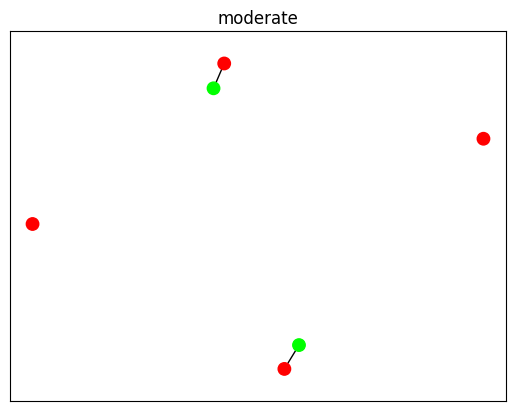

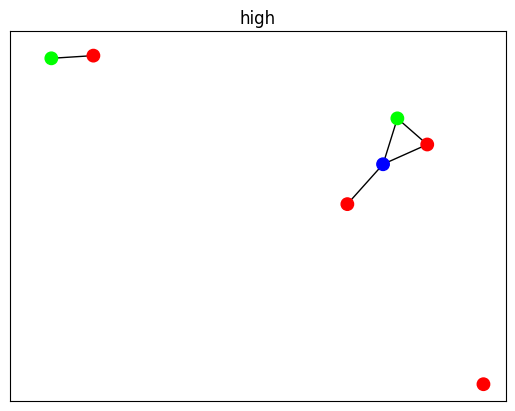

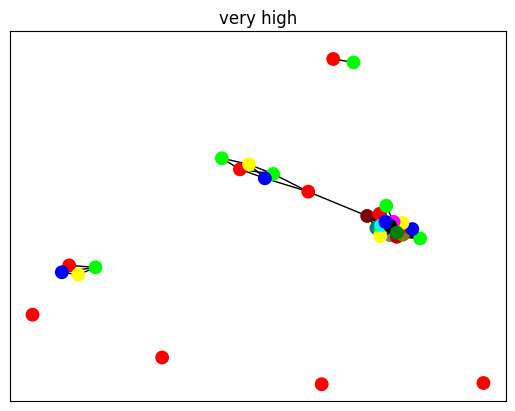

In [26]:
MG = nx.Graph(moderateGraph)
HG = nx.Graph(highGraph)
VHG = nx.Graph(veryHighGraph)
cMG = gcol.node_coloring(MG, opt_alg=1)
cHG = gcol.node_coloring(HG, opt_alg=1)
cVHG = gcol.node_coloring(VHG, opt_alg=1)

plt.figure(1)
plt.title("moderate")
nx.draw_networkx(MG,
                 pos=nx.spring_layout(MG, seed=3),
                 node_color=gcol.get_node_colors(MG, cMG, gcol.colorful),
                 with_labels=False,
                 node_size=80)
plt.figure(2)
plt.title("high")
nx.draw_networkx(HG,
                 pos=nx.spring_layout(HG, seed=3),
                 node_color=gcol.get_node_colors(HG, cHG, gcol.colorful),
                 with_labels=False,
                 node_size=80)
plt.figure(3)
plt.title("very high")
nx.draw_networkx(VHG,
                 pos=nx.spring_layout(VHG, seed=3),
                 node_color=gcol.get_node_colors(VHG, cVHG, gcol.colorful),
                 with_labels=False,
                 node_size=80)
plt.show()